# Overview
* Correlation commonly refers to the degree a pair of variables are linearly related
* Common methods:
    * Pearson's correlation coefficient (linear relationship)
    * Spearman's rank correlation coefficient
    * Kendall rank correlation coefficient
* Can utilize .corr method from pandas

### Correlation Feature Selection
* Good variables are highly correlated with the target
* Correlated predictor variables provide redundant information
* Variables should be correlated with the target but NOT correlated among themselves

### Correlation and Machine Learning
* Correlated features do not necessarily affect model accuracy per se. High dimensionality does
* If two features are highly correlated, the second one will add little information over the previous one: removing it helps reduce dimension
* Correlation affects model interpretability: linear models
* Different classifiers show different sensitivity to correlation

# Method 1: Brute Force Approach
* Scan features as they appear
* If a feature is correlated with the feature we are evaluating, we remove it
    * Fast
    * We may remove an important feature


# Method 2: Identify groups of correlated features
* Select the most predictive feature (from each group)
    * Build a small ML model using the features in the group
    * Other criteria, eg. Number of missing values
* Discard the rest of the features


In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [6]:
# load dataset

data = pd.read_csv('../precleaned-datasets/dataset_2.csv', nrows=50000)
data.shape

(50000, 109)

In [7]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

## Correlation Heatmap

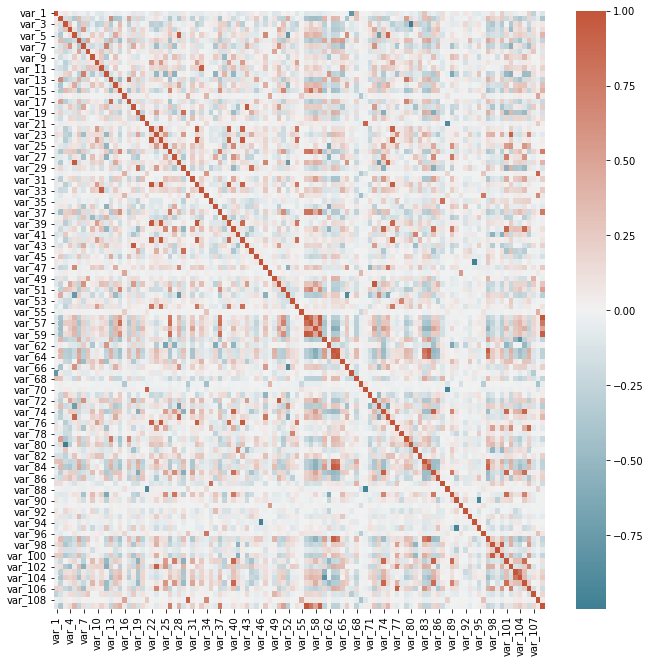

In [8]:
# visualise correlated features:
# default correlation method of pandas.corr is pearson
corrmat = X_train.corr(method='pearson')

cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots()
fig.set_size_inches(11,11)

sns.heatmap(corrmat, cmap=cmap)

In [9]:
# Looking at the heatmap, we see that var25 is highly correlated 
# with others in the dataset

# with this code we can get the other variable names
# and also print the correlation coefficient between var25 and 
# these variables:

c = 0

# iterate over each correlation value for var_5:
for i in corrmat.loc['var_5']:
    
    # if highly correlated
    if i>0.8:
        
        # print the variable name and the correlation coefficient
        print(corrmat.columns[c], i)
        
    c = c +1

var_5 1.0
var_28 0.9536721652384935
var_75 0.8616179292025201


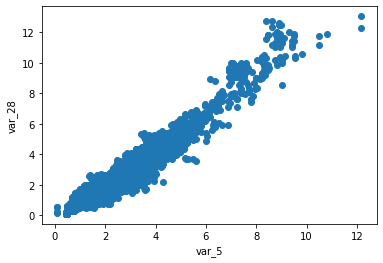

In [10]:
# now, let's plot the variables

plt.scatter(X_train['var_5'], X_train['var_28'])
plt.ylabel('var_28')
plt.xlabel('var_5')
plt.show()

## Brute Force Approach to remove correlated features

In [11]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything else
# without any further insight.

def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns
    col_corr = set()
    
    # create the correlation matrix
    corr_matrix = dataset.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corr_matrix.columns)):
        
        # check with other features
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

In [13]:
corr_features = correlation(X_train, 0.8)

0.8632980418993791 var_17 var_13
0.9813409653986921 var_24 var_22
0.9536721652384935 var_28 var_5
0.8341792843814466 var_29 var_19
0.990430734999363 var_32 var_22
0.9804113632495293 var_32 var_24
0.9443605986205844 var_33 var_11
0.9744609333741678 var_39 var_22
0.9431153866790611 var_39 var_24
0.9748779191363224 var_39 var_32
0.91910579117498 var_42 var_22
0.9672922649953389 var_42 var_24
0.9199183443060952 var_42 var_32
0.8567453370818933 var_42 var_39
0.9654741987814475 var_43 var_18
0.8358214281472581 var_44 var_29
0.8150241475398633 var_54 var_24
0.8287090109274785 var_54 var_42
0.837404481636077 var_57 var_15
0.8318090759398273 var_57 var_26
0.8207993837973238 var_57 var_37
0.8440857367712562 var_57 var_56
0.8131947525226287 var_59 var_26
0.8306144274586774 var_59 var_37
0.9757443944210573 var_59 var_56
0.9223172758595293 var_59 var_57
0.9244600573582408 var_64 var_63
0.8925221926487203 var_66 var_52
0.895397163737887 var_70 var_21
0.9702627369945973 var_72 var_50
0.88311916559035

In [14]:
len(set(corr_features))

40

In [15]:
#Drop these 
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 68), (15000, 68))

## Second approach: find GROUPS of highly correlated features

In [16]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

In [17]:
# build a dataframe with the correlation between features
# remember to take the absolute value of the correlation: coefficient is important and not the sign

corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,var_80,var_3,0.994923
1,var_3,var_80,0.994923
2,var_32,var_22,0.990431
3,var_22,var_32,0.990431
4,var_56,var_109,0.987777


In [18]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 27 correlated groups
out of 108 total features


In [20]:
for group in correlated_groups:
    print(group)
    print()

  feature1 feature2      corr
0   var_80    var_3  0.994923

   feature1 feature2      corr
2    var_32   var_22  0.990431
8    var_32   var_24  0.980411
13   var_32   var_39  0.974878
47   var_32   var_76  0.931718
56   var_32   var_42  0.919918

    feature1 feature2      corr
4     var_56  var_109  0.987777
11    var_56   var_59  0.975744
103   var_56   var_57  0.844086

   feature1 feature2      corr
16   var_72   var_50  0.970263

   feature1 feature2      corr
18   var_94   var_46  0.967895

   feature1 feature2      corr
22   var_43   var_18  0.965474

   feature1 feature2      corr
26   var_63   var_84  0.959138
40   var_63   var_97  0.940184
53   var_63   var_64  0.924460

   feature1 feature2      corr
30   var_28    var_5  0.953672
67   var_28   var_75  0.904413

   feature1 feature2      corr
32   var_88   var_70  0.948947
75   var_88   var_21  0.894393

   feature1 feature2      corr
36   var_11   var_33  0.944361

   feature1 feature2      corr
42   var_98  var_100  0.938

In [21]:
# For now, investigate group 1

group = correlated_groups[1]
group

,feature1,feature2,corr
2,var_32,var_22,0.990431
8,var_32,var_24,0.980411
13,var_32,var_39,0.974878
47,var_32,var_76,0.931718
56,var_32,var_42,0.919918


In [22]:
from sklearn.ensemble import RandomForestClassifier

# add all features of the group to a list
features = list(group['feature2'].unique())+['var_32']

# train a random forest 
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=39)

In [23]:
# get the feature importance attributed by the 
# random forest model (more on this in coming lectures)

importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

,feature,importance
2,var_39,0.194210
3,var_76,0.187360
0,var_22,0.167467
1,var_24,0.167054
4,var_42,0.147102
5,var_32,0.136807


In [ ]:
#Var 39 shows the highest importance according to random forest. 
#So I can select this variable and remove all remaining features from this group
#(should check to make sure we're not removing important features)

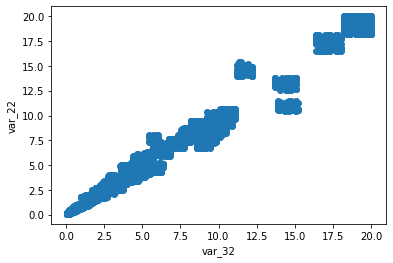

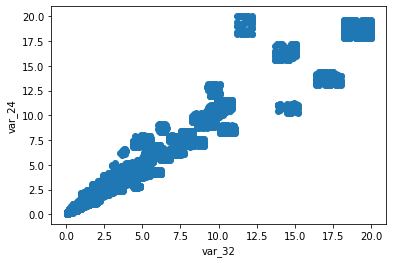

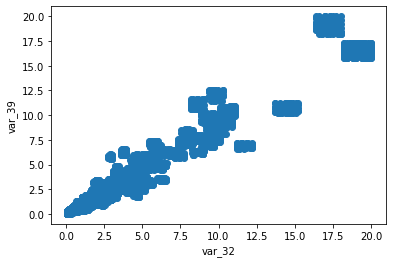

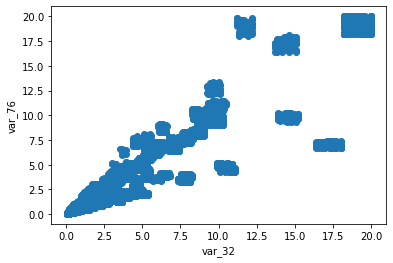

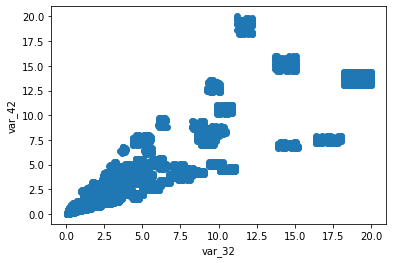

In [25]:
# BONUS:
# let's plot the correlation of the features in the correlated group from the
# previous cell

for feature in group['feature2']:
    plt.scatter(X_train['var_32'], X_train[feature])
    plt.xlabel('var_32')
    plt.ylabel(feature)
    plt.show()